In [1]:
import torch
%matplotlib inline

import os
import gzip
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
#from scipy import ndimage

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from datetime import datetime
from torchvision import datasets, transforms

from PIL import Image
from IPython.display import Image 



In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

print(dev)

cuda:0


In [3]:
batch_size = 10

In [4]:
from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image
import re


px_size = 60
py_size = 60

class DatasetMSE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.colour = torch.stack([self.get_colour(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.input_imgs = torch.stack([(self.tf((Image.open(file)))) for file in glob.glob(image_dir + '/00*')]).to(dev)
        self.add_colour()

    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    def get_labels(self, x):
        new_x = torch.zeros(6,px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[self.col_sim(new_d3[i][j])][i][j] = 1
                
        return new_x
        
    def get_colour(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
        
    def add_colour(self):
        print(self.input_imgs.shape)
        for i in range(self.input_imgs.shape[0]):
            print(i)
            self.input_imgs[i][0][self.colour[i] == 3] += 0.2
            self.input_imgs[i][1][self.colour[i] == 4] += 0.2
            self.input_imgs[i][2][self.colour[i] == 5] += 0.2
        self.input_imgs = self.input_imgs.clamp(0, 1)
            #new_x[1][y[i]==4] += 0.5
            #new_x[2][y[i]==5] += 0.5
            #new_x[2][y[i] == 0] += 0.5
            #new_x[1][y[i]==0] += 0.5
        
    
    def print_tensor(self, x):
        print(self.input_imgs[x])

In [32]:
dset_mse = DatasetMSE("Original","Labeled")
train_loader_MSE = torch.utils.data.DataLoader(dset_mse, shuffle=True, batch_size=batch_size)
#dset_mse.print_tensor(2)

torch.Size([9, 3, 60, 60])
0
1
2
3
4
5
6
7
8


In [15]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
def initial_seed(batch_size):
    return torch.zeros(batch_size, 3, px_size, py_size)

# Encode colour classes 1
def to_classes(d):
    d = d*255
    x = torch.zeros(6, d.shape[1], d.shape[2])
    # RED 255,0,0
    x[0][(d[0] > 220) & (d[1] < 20) & (d[2] < 20)] = 1
    # BROWN 127,0,0
    x[1][(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[2][(d[0] > 20) & (d[1] > 30) & (d[2] < 230)] = 1
    # LIGHT BLUE 0,255,255
    x[3][(d[0] < 100) & (d[1] > 100) & (d[2] > 100)] = 1
    # DARK BLUE 0,0,255
    x[4][(d[0] < 30) & (d[1] < 30) & (d[2] > 150)] = 1
    # GREEN 0,255,0
    x[5][(d[0] < 120) & (d[1] > 140) & (d[2] < 160)] = 1
    return torch.FloatTensor(x)

# Encode colour classes 2
def to_class(d):
    d = d*255
    x = torch.zeros(d.shape[1], d.shape[2])
    # RED 255,0,0
    #x[(d[0] > 180) & (d[1] < 60) & (d[2] < 60)] = 0
    # BROWN 127,0,0
    x[(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[(d[0] > 100) & (d[1] > 100) & (d[2] < 100)] = 2
    # LIGHT BLUE 0,255,255
    x[(d[0] < 60) & (d[1] > 180) & (d[2] > 180)] = 3
    # DARK BLUE 0,0,255
    x[(d[0] < 60) & (d[1] < 60) & (d[2] > 180)] = 4
    # GREEN 0,255,0
    x[(d[0] < 70) & (d[1] > 170) & (d[2] < 70)] = 5
    return torch.FloatTensor(x)

colors = {
    0:torch.FloatTensor([255.0, 0.0, 0.0]).to(dev),
    1:torch.FloatTensor([127.0, 0.0, 0.0]).to(dev),
    2:torch.FloatTensor([255.0, 255.0, 0.0]).to(dev),
    3:torch.FloatTensor([0.0, 255.0, 255.0]).to(dev),
    4:torch.FloatTensor([0.0, 0.0, 255.0]).to(dev),
    5:torch.FloatTensor([0.0, 255.0, 0.0]).to(dev)
    }
          
    
# Get RGB class channels
def get_rgb(x):
    return x.transpose(0,1)[3:9].transpose(0,1)

# Transform to display image
ts = transforms.ToPILImage()

# Get max class value and convert to RGB for the C classes
def max_rgb(x):
    newimg = torch.zeros(x.shape[0], px_size, px_size, 3).to(dev)
    for i in range(x.shape[0]):
        # RED 255, 0, 0
        newimg[i][torch.argmax(x[i],dim=0) == 0] = colors[0]
        # BROWN 127 0 0 
        newimg[i][torch.argmax(x[i],dim=0) == 1] = colors[1]
        # YELLOW 255, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 2] = colors[2]
        # L BLUE 0, 255, 255
        newimg[i][torch.argmax(x[i],dim=0) == 3] = colors[3]
        # D BLUE 0, 0, 255
        newimg[i][torch.argmax(x[i],dim=0) == 4] = colors[4]
        # GREEN 0, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 5] = colors[5]
    
    return (newimg/255.0).transpose(1,3).transpose(2,3)


def max_rgba(x):
    newimg = torch.zeros(px_size, px_size, 3)
    # RED 255, 0, 0
    newimg[torch.argmax(x,dim=0) == 0] = torch.FloatTensor([255.0, 0.0, 0.0])
    # BROWN 127 0 0 
    newimg[torch.argmax(x,dim=0) == 1] = torch.FloatTensor([127.0, 0.0, 0.0])
    # YELLOW 255, 255, 0
    newimg[torch.argmax(x,dim=0) == 2] = torch.FloatTensor([255.0, 255.0, 0.0])
    # L BLUE 0, 255, 255
    newimg[torch.argmax(x,dim=0) == 3] = torch.FloatTensor([0.0, 255.0, 255.0])
    # D BLUE 0, 0, 255
    newimg[torch.argmax(x,dim=0) == 4] = torch.FloatTensor([0.0, 0.0, 255.0])
    # GREEN 0, 255, 0
    newimg[torch.argmax(x,dim=0) == 5] = torch.FloatTensor([0.0, 255.0, 0.0])
    
    alpha = torch.max(x, dim=0).values.to(dev)
    #alpha = alpha/torch.max(alpha)
    newimg = (newimg/255.0).to(dev)
    newimg = torch.cat((newimg, alpha.view(px_size, px_size, 1)), dim=2)
    print(newimg.shape)
    return newimg.transpose(0,2).transpose(1,2)

# Flatten dimension
def loss_classes(x):
    y = torch.flatten(x,1,2)
    return y


In [ ]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 10 images because batch_size=10 for the dataloaders
inputs, labels = next(iter(train_loader_MSE))
# Make a grid from batch
out = torchvision.utils.make_grid(torch.cat((inputs, max_rgb(labels)),dim=0), nrow=batch_size)
imshow(out, title="Sample Batch (Image and Ground Truth)")


In [5]:
batch_size = 10

In [6]:
# Cross Entropy

from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image


px_size = 60
py_size = 60

class DatasetCE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.input_imgs = torch.stack([self.tf((Image.open(file))) for file in glob.glob(image_dir + '/*')]).to(dev)
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/*')]).to(dev)
        #self.add_colour()
    
    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    # (3, x, y)
    def get_labels(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
    
    def add_colour(self):
        y = self.label_imgs.clone().detach()
        for i in range(self.input_imgs.shape[0]):
            self.input_imgs[i][0][y[i] == 3] += 0.3
            self.input_imgs[i][1][y[i] == 4] += 0.3
            self.input_imgs[i][2][y[i] == 5] += 0.3
        self.input_imgs = self.input_imgs.clamp(0, 1)


In [7]:
# Cross Entropy

dsetCE = DatasetCE("Original","Labeled")
train_loader_CE = torch.utils.data.DataLoader(dsetCE, shuffle=True, batch_size=batch_size)
dsetCE.__len__()

150

In [8]:
train_DS, test_DS = torch.utils.data.random_split(dsetCE, [120, 30])
train_loader_CE = torch.utils.data.DataLoader(train_DS, shuffle=True, batch_size=batch_size)
test_loader_CE = torch.utils.data.DataLoader(test_DS, shuffle=True, batch_size=1)

In [16]:
# Cellular automata class
class CAModel(nn.Module):

    def __init__(self, channel_n,
                 fire_rate=0.5, device=torch.device("cpu")):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        self.to(self.device)
        
        # Neural network model
        self.conv1 = nn.Conv2d(45, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv1a = nn.Conv2d(32, 24, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(24, 16, kernel_size=1)
        self.conv3 = nn.Conv2d(16, 6, kernel_size=1)
        
        # Pre-defined weights for embedding information
        self.prewitt_x = torch.FloatTensor([[1,0,-1],[1,0,-1],[1,0,-1]]).to(dev)
        self.prewitt_y = torch.FloatTensor([[1,1,1],[0,0,0],[-1,-1,-1]]).to(dev)
        
        self.sobel_x = torch.FloatTensor([[1,0,-1],[2,0,-2],[1,0,-1]]).to(dev)
        self.sobel_y = torch.FloatTensor([[1,2,1],[0,0,0],[-1,-2,-1]]).to(dev)
        
        # If you want learnable weights
        # self.pre_weight = nn.Conv2d(9,27,kernel_size=3, padding=1)
        
    def perceive(self, x):

        def _perceive_with(x, weight):
            size = weight.shape[0]
            padding = (size-1)/2
            weight = weight.view(1,1,size,size).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, weight, padding=int(padding), groups=self.channel_n)
        
        # 3x3 Sobel and Prewitt operators
        wa_1 = self.sobel_x
        wa_2 = self.sobel_y
        wa_3 = self.prewitt_x
        wa_4 = self.prewitt_y
        
        # Normalisation of these
        wa_1/=torch.sum(torch.abs(wa_1))
        wa_2/=torch.sum(torch.abs(wa_2))
        wa_3/=torch.sum(torch.abs(wa_3))
        wa_4/=torch.sum(torch.abs(wa_4))

        # Apply convolutions with these filters
        y1 = _perceive_with(x, wa_1)
        y2 = _perceive_with(x, wa_2)
        y3 = _perceive_with(x, wa_1)
        y4 = _perceive_with(x, wa_2)
                
        # Concatenate
        y = torch.cat((x,y1,y2,y3,y4),1)
        return y
    
    
    def forward(self, steps, x, last=False):
        x = torch.cat((x, torch.zeros(batch_size,6,px_size,px_size).to(dev)), dim=1)
        if last == True:
            epoch_history = []
            for i in range(steps):
                epoch_history.append(x.detach()[:,3:9,:])
                
                b = self.perceive(x)
                bb = self.conv3(self.conv2(self.relu(self.conv1a(self.relu(self.conv1(b))))))
                
                c = x.detach().clone()
                #stochastic = torch.rand([bb.size(0),bb.size(1),bb.size(2),bb.size(3)])<self.fire_rate
                #stochastic = stochastic.float().to(self.device)

                #d = bb*stochastic
                d = bb
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
                
            return x, epoch_history
                
        else:
            for i in range(steps):
                b = self.perceive(x)
                bb = self.conv3(self.conv2((self.conv1a(self.relu(self.conv1(b))))))
                
                c = x.detach().clone()
                #stochastic = torch.rand([bb.size(0),bb.size(1),bb.size(2),bb.size(3)])<self.fire_rate
                #stochastic = stochastic.float().to(self.device)

                #d = bb*stochastic
                d = bb
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
            return x

In [19]:
# Load model, set loss function, optimizer and scheduler

model = CAModel(9,fire_rate=0.5,device=dev)
#model = torch.load('modelcollab1.pth')
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.00036, betas=(0.9, 0.999))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30,60,90], 0.6)
#loss1 = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

# RED, BROWN, YELLOW, LBLUE, DBLUE, GREEN
w = torch.FloatTensor([2,1, 1.05, 8.4, 9, 8.1]).to(dev)
loss2 = torch.nn.CrossEntropyLoss(weight=w, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
#loss = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction='mean', log_target=False)
loss_mse = []
loss_ce = []
history = []
epochs = 200

batch_size=10

In [12]:
# Only needed for collaborative automata
mask1 = torch.zeros(1,6,px_size,px_size).to(dev)
mask2 = torch.zeros(1,6,px_size,px_size).to(dev)
k = mask1.shape[2]
for i in range(k):
    for j in range(k):
        mask1[:,:,i,j] = (i + j + 1) % 2
        mask2[:,:,i,j] = (i + j) % 2

In [ ]:
# MSE training loop
for epoch in range(epochs):
    i = 0
    last = False
    if epoch == epochs-1:
        last = True
    for batch in train_loader_MSE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        out = loss1(b,targets)
        print("Loss =", out)
        loss_mse.append(float(out))
        c = b.detach().clone()
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            del c
            
        i += 1
        optimizer.zero_grad()
        out.backward()
        optimizer.step()

In [19]:
torch.save(model, 'modelMSE.pth')

In [25]:
from array2gif import write_gif
eh = [(max_rgb(epoch_history[i])[1]*255).cpu().detach().numpy() for i in range(len(epoch_history))]
#eh = [(max_rgb(epoch_history[i][0])*255).cpu().detach().numpy() for i in range(len(epoch_history))]

write_gif(eh, 'final.gif', fps=1)
#eh[0].shape
#torch.stack(epoch_history)[0].shape

Loss = tensor(1.7979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


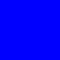

Learning rate:  0.00036
Loss = tensor(1.7985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


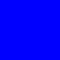

Learning rate:  0.00036
Loss = tensor(1.7961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


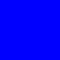

Learning rate:  0.00036
Loss = tensor(1.7958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


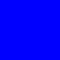

Learning rate:  0.00036
Loss = tensor(1.7948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


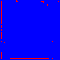

Learning rate:  0.00036
Loss = tensor(1.7943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


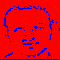

Learning rate:  0.00036
Loss = tensor(1.7911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


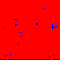

Learning rate:  0.00036
Loss = tensor(1.7902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


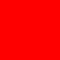

Learning rate:  0.00036
Loss = tensor(1.7897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


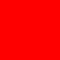

Learning rate:  0.00036
Loss = tensor(1.7867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


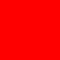

Learning rate:  0.00036
Loss = tensor(1.7852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


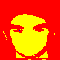

Learning rate:  0.00036
Loss = tensor(1.7810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


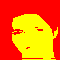

Learning rate:  0.00036
Loss = tensor(1.7778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


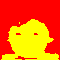

Learning rate:  0.00036
Loss = tensor(1.7774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


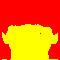

Learning rate:  0.00036
Loss = tensor(1.7690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


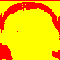

Learning rate:  0.00036
Loss = tensor(1.7623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


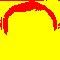

Learning rate:  0.00036
Loss = tensor(1.7587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


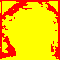

Learning rate:  0.00036
Loss = tensor(1.7483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


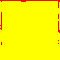

Learning rate:  0.00036
Loss = tensor(1.7302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


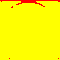

Learning rate:  0.00036
Loss = tensor(1.7183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7285, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


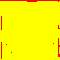

Learning rate:  0.00036
Loss = tensor(1.7129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


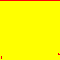

Learning rate:  0.00036
Loss = tensor(1.6744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


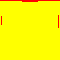

Learning rate:  0.00036
Loss = tensor(1.6912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


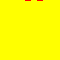

Learning rate:  0.00036
Loss = tensor(1.6617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


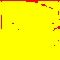

Learning rate:  0.00036
Loss = tensor(1.6629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


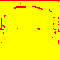

Learning rate:  0.00036
Loss = tensor(1.6538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


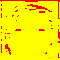

Learning rate:  0.00036
Loss = tensor(1.6303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


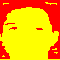

Learning rate:  0.00036
Loss = tensor(1.6488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


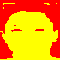

Learning rate:  0.00036
Loss = tensor(1.6212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


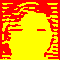

Learning rate:  0.00036
Loss = tensor(1.5592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


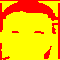

Learning rate:  0.00036
Loss = tensor(1.5694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


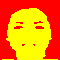

Learning rate:  0.00036
Loss = tensor(1.5905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


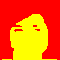

Learning rate:  0.00036
Loss = tensor(1.5522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


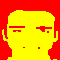

Learning rate:  0.00036
Loss = tensor(1.5425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


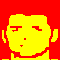

Learning rate:  0.00036
Loss = tensor(1.5661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


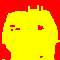

Learning rate:  0.00036
Loss = tensor(1.5236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


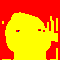

Learning rate:  0.00036
Loss = tensor(1.4987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


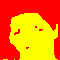

Learning rate:  0.00036
Loss = tensor(1.5337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5400, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


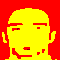

Learning rate:  0.00036
Loss = tensor(1.4995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


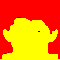

Learning rate:  0.00036
Loss = tensor(1.5362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


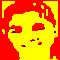

Learning rate:  0.00036
Loss = tensor(1.5383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


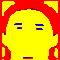

Learning rate:  0.00036
Loss = tensor(1.5099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


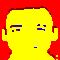

Learning rate:  0.00036
Loss = tensor(1.5020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


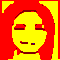

Learning rate:  0.00036
Loss = tensor(1.5037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


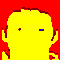

Learning rate:  0.00036
Loss = tensor(1.4845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


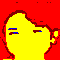

Learning rate:  0.00036
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


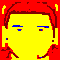

Learning rate:  0.00036
Loss = tensor(1.5272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4938, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


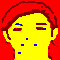

Learning rate:  0.00036
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


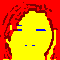

Learning rate:  0.00036
Loss = tensor(1.4798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


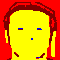

Learning rate:  0.00036
Loss = tensor(1.4461, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


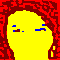

Learning rate:  0.00036
Loss = tensor(1.4664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


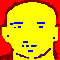

Learning rate:  0.00036
Loss = tensor(1.4645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4389, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


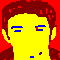

Learning rate:  0.00036
Loss = tensor(1.4250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


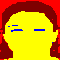

Learning rate:  0.00036
Loss = tensor(1.4054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


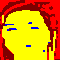

Learning rate:  0.00036
Loss = tensor(1.4237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


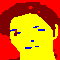

Learning rate:  0.00036
Loss = tensor(1.3965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


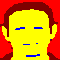

Learning rate:  0.00036
Loss = tensor(1.3706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


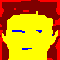

Learning rate:  0.00036
Loss = tensor(1.3625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


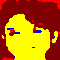

Learning rate:  0.00036
Loss = tensor(1.4258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


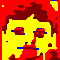

Learning rate:  0.00036
Loss = tensor(1.3505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


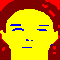

Learning rate:  0.00036
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


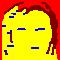

Learning rate:  0.00036
Loss = tensor(1.3537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


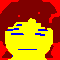

Learning rate:  0.00036
Loss = tensor(1.4136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


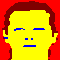

Learning rate:  0.00036
Loss = tensor(1.3639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


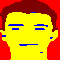

Learning rate:  0.00036
Loss = tensor(1.3398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4157, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


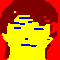

Learning rate:  0.00036
Loss = tensor(1.3811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


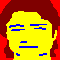

Learning rate:  0.00036
Loss = tensor(1.3747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


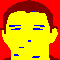

Learning rate:  0.00036
Loss = tensor(1.3604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


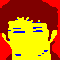

Learning rate:  0.00036
Loss = tensor(1.3707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


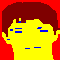

Learning rate:  0.00036
Loss = tensor(1.3748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


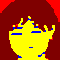

Learning rate:  0.00036
Loss = tensor(1.3727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


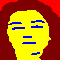

Learning rate:  0.00036
Loss = tensor(1.3669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


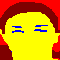

Learning rate:  0.00036
Loss = tensor(1.3525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


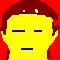

Learning rate:  0.00036
Loss = tensor(1.3932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3389, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


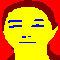

Learning rate:  0.00036
Loss = tensor(1.3510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


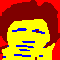

Learning rate:  0.00036
Loss = tensor(1.3245, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


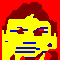

Learning rate:  0.00036
Loss = tensor(1.3167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


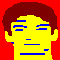

Learning rate:  0.00036
Loss = tensor(1.3672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


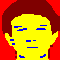

Learning rate:  0.00036
Loss = tensor(1.3538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


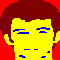

Learning rate:  0.00036
Loss = tensor(1.3690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


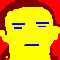

Learning rate:  0.00036
Loss = tensor(1.3432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


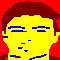

Learning rate:  0.00036
Loss = tensor(1.3226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


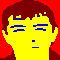

Learning rate:  0.00036
Loss = tensor(1.3796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


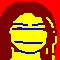

Learning rate:  0.00036
Loss = tensor(1.3508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


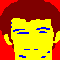

Learning rate:  0.00036
Loss = tensor(1.3501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3352, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


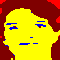

Learning rate:  0.00036
Loss = tensor(1.3448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


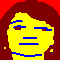

Learning rate:  0.00036
Loss = tensor(1.3486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


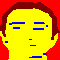

Learning rate:  0.00036
Loss = tensor(1.4031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


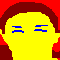

Learning rate:  0.00036
Loss = tensor(1.3562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


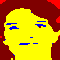

Learning rate:  0.00036
Loss = tensor(1.3510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


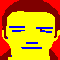

Learning rate:  0.00036
Loss = tensor(1.3511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


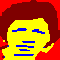

Learning rate:  0.00021600000000000002
Loss = tensor(1.3752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


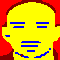

Learning rate:  0.00021600000000000002
Loss = tensor(1.3458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


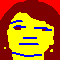

Learning rate:  0.00021600000000000002
Loss = tensor(1.3544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


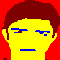

Learning rate:  0.00021600000000000002
Loss = tensor(1.3635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


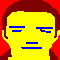

Learning rate:  0.00021600000000000002
Loss = tensor(1.3689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


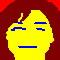

Learning rate:  0.00021600000000000002
Loss = tensor(1.3777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


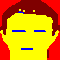

Learning rate:  0.00021600000000000002
Loss = tensor(1.3542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


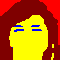

Learning rate:  0.00021600000000000002
Loss = tensor(1.3917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


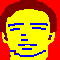

Learning rate:  0.00021600000000000002
Loss = tensor(1.3541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


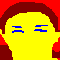

Learning rate:  0.00021600000000000002
Loss = tensor(1.3276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


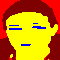

Learning rate:  0.00021600000000000002
Loss = tensor(1.4073, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3200, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3375, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


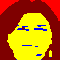

Learning rate:  0.00021600000000000002
Loss = tensor(1.3392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


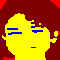

Learning rate:  0.00021600000000000002
Loss = tensor(1.3438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


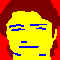

Learning rate:  0.00021600000000000002
Loss = tensor(1.3613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


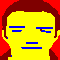

Learning rate:  0.00021600000000000002
Loss = tensor(1.4053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


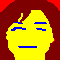

Learning rate:  0.00021600000000000002
Loss = tensor(1.3495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


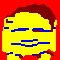

Learning rate:  0.00021600000000000002
Loss = tensor(1.3290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


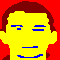

Learning rate:  0.00021600000000000002
Loss = tensor(1.4015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


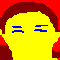

Learning rate:  0.00021600000000000002
Loss = tensor(1.3570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


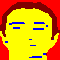

Learning rate:  0.00021600000000000002
Loss = tensor(1.3722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


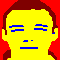

Learning rate:  0.00021600000000000002
Loss = tensor(1.3382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


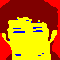

Learning rate:  0.00021600000000000002
Loss = tensor(1.3319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3280, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


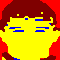

Learning rate:  0.00021600000000000002
Loss = tensor(1.3567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


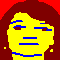

Learning rate:  0.00021600000000000002
Loss = tensor(1.3763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


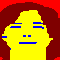

Learning rate:  0.00021600000000000002
Loss = tensor(1.3257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


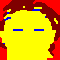

Learning rate:  0.00021600000000000002
Loss = tensor(1.3425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3695, device='cuda:0', grad_fn=<NllLoss2DBackward>)


KeyboardInterrupt: 

In [20]:
# Cross-entropy training loop
for epoch in range(epochs):
    i = 0
    # Last is so we can record the steps from the final epoch
    last = False
    if epoch == epochs:
        last = True
    for batch in train_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        #out = loss1(b,c) + 4*loss1(b[3],c[3])+15*loss1(b[4],c[4])+4*loss1(b[5],c[5])
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_ce.append(float(out))
        c = b.detach().clone()
        
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            print("Learning rate: ", scheduler.get_last_lr()[0])
            del c
        i += 1
        
        optimizer.zero_grad()
        out.backward()
        optimizer.step()
    scheduler.step()

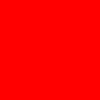

In [26]:
from IPython.display import display, Image
Image('final.gif')

In [ ]:
plt.plot(loss_mse)

In [27]:
torch.save(model, 'naive.pth')

In [31]:
torch.argmax(get_rgb(x), dim=1).flatten(1,2).shape

torch.Size([5, 4900])

torch.Size([60, 60, 4])


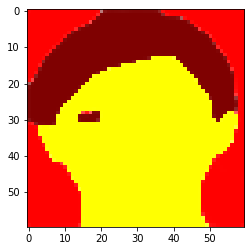

In [28]:
# Show certainty of pixels

a = max_rgba(b[0]).detach().clone().to('cpu')
plt.imshow(a.transpose(1,2).transpose(0,2))
plt.show()

In [39]:
# Save final iterations as gif

epoch_new = [ts(i) for i in epoch_history]
epoch_new[0].save('anitest.gif',
               save_all=True,
               append_images=epoch_new[1:],
               duration=1000,
               loop=0)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score 
from sklearn.metrics import ConfusionMatrixDisplay

def dice(pred, truth, epsilon=1e-6):
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)
    
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    d5 = 2*TP+FN+FP
    if d5 == 0:
        d5 = epsilon
    dice = 2*TP/d5
    
    return dice  

# Precision, Recall, Accuracy and Specificity Score
def pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)

    # Calculate FP, FN, TP, TN
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d1[np.where(d1==0)] = -1
    d2 = TP+FN
    d2[np.where(d2==0)] = -1
    d3 = TP+TN+FP+FN
    d3[np.where(d3==0)] = -1
    d4 = TN+FP
    d4[np.where(d4==0)] = -1

    # Calculate and return scores
    precision = TP/d1
    recall = TP/d2
    accuracy = (TP+TN)/d3
    specificity = TN/d4
    
    return precision, recall, accuracy, specificity

# Recall Score
def overall_pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()
    
    x = confusion_matrix(pred, target)

    FP = x.sum(axis=0) - np.diag(x)  
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Sum the values for overall values
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d2 = TP+FN
    d3 = TP+TN+FP+FN
    d4 = TN+FP
    
    # Calculate and return scores and deal with potential 0 denominators
    if d1 > 0:
        precision = TP/d1
    else:
        precision = -1
        
    if d2 > 0:
        recall = TP/d2
    else:
        recall = -1
    
    if d3 > 0:
        accuracy = (TP+TN)/d3
    else:
        d3 = -1
        
    if d4 > 0:
        specificity = TN/d4
    else:
        specificity = -1
    
    return precision, recall, accuracy, specificity

# Mutual Information
def mi(pred, target):
    print(pred.squeeze().shape)
    print(target.flatten().shape)
    return mutual_info_score(pred.flatten().cpu(), target.flatten().cpu())

def get_confusion(pred, target):
    pred = pred.view(-1).cpu()
    target = target.view(-1).cpu()
    x = confusion_matrix(pred.cpu(), target.cpu())
    return x

def print_confusion(conf):
    xt = ["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"]
    sns.set(font_scale=1.4, rc={'figure.figsize':(11.7,8.27)}) 
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt='g', xticklabels=xt, yticklabels=xt)
    plt.savefig("confusion.png")

In [13]:
# Empty lists for precision, recall, accuracy, specificity, DICE

po_list = []
ro_list = []
ao_list = []
so_list = []

p_list = []
r_list = []
a_list = []
s_list = []

dice_list = []
mi_list = []

Loss = tensor(1.6257, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


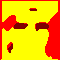

1.6256805658340454
Loss = tensor(1.2909, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


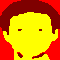

1.2909468412399292
Loss = tensor(1.3848, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


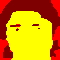

1.3847682476043701
Loss = tensor(1.3942, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


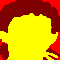

1.394240140914917
Loss = tensor(1.2760, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


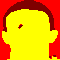

1.275985836982727
Loss = tensor(1.3382, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


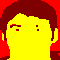

1.338197946548462
Loss = tensor(1.3876, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


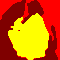

1.3876286745071411
Loss = tensor(1.3286, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


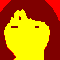

1.3285850286483765
Loss = tensor(1.3165, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


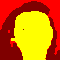

1.3164860010147095
Loss = tensor(1.3535, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


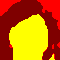

1.3534773588180542
Loss = tensor(1.2847, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


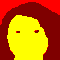

1.284747838973999
Loss = tensor(1.2992, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


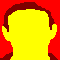

1.2991952896118164
Loss = tensor(1.4886, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


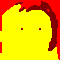

1.488637089729309
Loss = tensor(1.2852, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


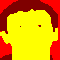

1.2851858139038086
Loss = tensor(1.3334, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


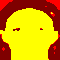

1.3333861827850342
Loss = tensor(1.2625, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


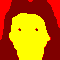

1.2625274658203125
Loss = tensor(1.3842, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


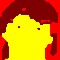

1.3842464685440063
Loss = tensor(1.2911, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


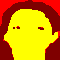

1.2910785675048828
Loss = tensor(1.4117, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


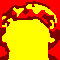

1.4116612672805786
Loss = tensor(1.3177, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


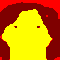

1.317700982093811
Loss = tensor(1.2965, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


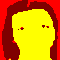

1.2964756488800049
Loss = tensor(1.3595, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


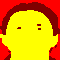

1.3594715595245361
Loss = tensor(1.3431, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


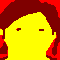

1.3431376218795776
Loss = tensor(1.3827, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


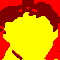

1.3826584815979004
Loss = tensor(1.3589, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


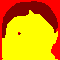

1.358903169631958
Loss = tensor(1.4311, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


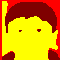

1.431139349937439
Loss = tensor(1.2611, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


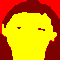

1.26105797290802
Loss = tensor(1.3772, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


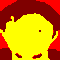

1.377220630645752
Loss = tensor(1.3926, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


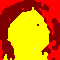

1.392622709274292
Loss = tensor(1.4908, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


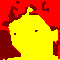

1.490848183631897


In [14]:
# Inference and test loss
loss_test_ce = []
batch_size=1
conf_running = torch.zeros(6,6)

with torch.no_grad():
    for batch in test_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)

        b = get_rgb(x)
        pred = torch.argmax(b, dim=1)
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_test_ce.append(float(out))
        c = b.detach().clone()
        
        target = targets.detach().long()
        
        # Log metrics
        p,r,a,s = overall_pras(pred, target)
        po_list.append(p)
        ro_list.append(r)
        ao_list.append(a)
        so_list.append(s)
        
        d = dice(pred, target)
        dice_list.append(d.item())
        
        m = mi(pred, target)
        mi_list.append(m)
        
        p,r,a,s = pras(pred, target)
        p_list.append(p)
        r_list.append(r)
        a_list.append(a)
        s_list.append(s)
        
        conf_running += get_confusion(pred, target)
        
        for i in range(batch_size):
            display(ts(max_rgb(c)[i]))
        del c
        print(float(out))

In [16]:
boxplot_p = np.array(p_list)
boxplot_r = np.array(r_list)
boxplot_a = np.array(a_list)
boxplot_s = np.array(s_list)
boxplot_mi = np.array(mi_list)

np.save('metrics/naive_p.npy', boxplot_p)
np.save('metrics/naive_r.npy', boxplot_r)
np.save('metrics/naive_a.npy', boxplot_a)
np.save('metrics/naive_s.npy', boxplot_s)
np.save('metrics/naive_m.npy', boxplot_mi)
np.save('metrics/naive_dice.npy', dice_list)

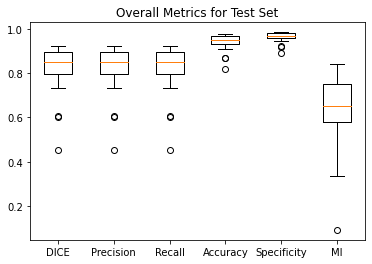

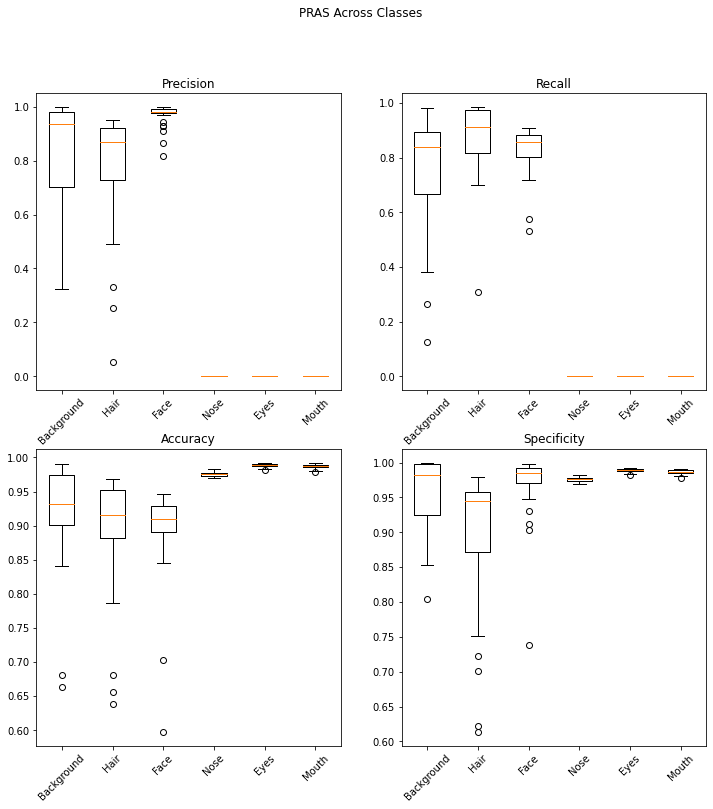

In [17]:
pras_overall_list = [dice_list, po_list, ro_list, ao_list, so_list, mi_list]
#sns.boxplot(x=np.array(pras_overall_list), y=np.array([1,2,3,4]))
plt.boxplot(pras_overall_list)
plt.xticks([1,2,3,4,5,6],["DICE", "Precision", "Recall", "Accuracy", "Specificity", "MI"])
plt.title("Overall Metrics for Test Set")
plt.savefig("1NaivePras.png")


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
ax1.boxplot(boxplot_p)
ax1.set_title("Precision")
ax1.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax2.boxplot(boxplot_r)
ax2.set_title("Recall")
ax2.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax3.boxplot(boxplot_a)
ax3.set_title("Accuracy")
ax3.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax4.boxplot(boxplot_s)
ax4.set_title("Specificity")
ax4.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

fig.set_figwidth(12)
fig.set_figheight(12)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
fig.suptitle('PRAS Across Classes')

plt.savefig("1NaivePrasClass.png")

In [22]:
np.save('1dice_naive.npy', np.array(dice_list))

In [21]:
# Analysing stability using number of steps
last = False
stability_dice = []
images = []
batch_size = 1


for i in range(1,50):
    dice_list=[]
    with torch.no_grad():
        for batch in test_loader_CE:
            inputs, targets = batch
            if last == True:
                x, epoch_history = model.forward(i*10, inputs, last=last)
            else:
                x = model.forward(i*10, inputs, last=last)

            b = get_rgb(x)
            pred = torch.argmax(b, dim=1)
            out = loss2(b, targets.detach().long())
            c = b.detach().clone()
            images.append(c)
        
            target = targets.detach().long()
        
            d = dice(pred, target)
            dice_list.append(d.item())
                
            
        print("Steps: " + str(10*i) + " " + str(np.mean(dice_list)))
        stability_dice.append(np.mean(dice_list))
    

Steps: 10 0.7817777777777778
Steps: 20 0.797861111111111
Steps: 30 0.807185185185185
Steps: 40 0.813111111111111
Steps: 50 0.8173148148148148
Steps: 60 0.8200833333333333
Steps: 70 0.8221666666666667
Steps: 80 0.8239166666666666
Steps: 90 0.8246759259259259
Steps: 100 0.8249537037037036
Steps: 110 0.8254444444444444
Steps: 120 0.8258425925925927
Steps: 130 0.8262314814814816
Steps: 140 0.8264907407407409
Steps: 150 0.826648148148148
Steps: 160 0.8268796296296297
Steps: 170 0.8270833333333333
Steps: 180 0.8273611111111112
Steps: 190 0.8274814814814814
Steps: 200 0.8275185185185183
Steps: 210 0.8276296296296296
Steps: 220 0.8277500000000001
Steps: 230 0.8278148148148147
Steps: 240 0.8277685185185184
Steps: 250 0.8277222222222221
Steps: 260 0.8277407407407408
Steps: 270 0.8277962962962963
Steps: 280 0.8278611111111108
Steps: 290 0.827824074074074
Steps: 300 0.8277592592592591
Steps: 310 0.8277777777777778
Steps: 320 0.8278055555555555
Steps: 330 0.8278611111111112
Steps: 340 0.82782407407

In [14]:
# Save the DICE scores for the stability plot
np.save('metrics/stability_naive.npy', stability_dice)